# OWL-ViT minimal example

This Colab shows how to **load a pre-trained OWL-ViT checkpoint** and use it to
**get object detection predictions** for an image.

# Download and install OWL-ViT

OWL-ViT is implemented in [Scenic](https://github.com/google-research/scenic). The cell below installs the Scenic codebase from GitHub and imports it.

In [80]:
# !rm -rf *
# !rm -rf .config
# !rm -rf .git
# !git clone https://github.com/google-research/scenic.git .
# !python -m pip install -q .
# !python -m pip install -r scenic/projects/baselines/clip/requirements.txt
# !echo "Done."

In [81]:
import os

import jax
from matplotlib import pyplot as plt
import numpy as np
from scenic.projects.owl_vit import models
from scenic.projects.owl_vit.configs import clip_b32, clip_l14, clip_b16
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

# Choose config

In [82]:
# config = clip_b32.get_config()  # worst
# checkpoint_path = './clip_vit_b32_b0203fc'

config = clip_b16.get_config()  # good trade off
checkpoint_path = './clip_vit_b16_6171dab'

#config = clip_l14.get_config()  # best
#checkpoint_path = './clip_vit_l14_d83d374'


# Load the model and variables

In [83]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [84]:
config.init_from.checkpoint_path

'gs://scenic-bucket/owl_vit/checkpoints/clip_vit_b16_6171dab'

In [85]:

variables = module.load_variables(checkpoint_path)

# Prepare image

In [86]:
# filename = os.path.join(skimage.data_dir, 'astronaut.png')
#filename = './images/dogpark.jpg'
#filename = './images/trees.jpeg'
#filename = './images/cows.jpeg'
#filename = './images/straw.jpeg'
filename = './images/peas.jpeg'
#filename = 'https://static4.depositphotos.com/1004288/279/i/450/depositphotos_2799328-stock-photo-green-peas-served-on-a.jpg'
#filename = 'https://miro.medium.com/max/480/1*yuWSTpGIelzw_rlmZyLnlA@2x.jpeg'
filename = 'http://yangjie.org/peas.jpeg'
print(filename)

http://yangjie.org/peas.jpeg


In [87]:
from PIL import Image
import requests
from io import BytesIO


#response = requests.get(filename)
#print(filename)
#img = Image.open(BytesIO(response.content))
#img

(768, 768, 3)


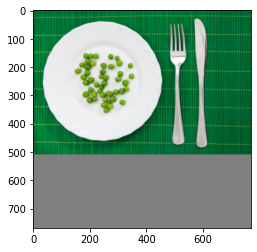

In [88]:
# Load example image:
# filename = os.path.join(skimage.data_dir, 'astronaut.png')

#print(filename)
if filename.lower().startswith('http'):
    response = requests.get(filename)
    image = Image.open(BytesIO(response.content))
    image_uint8 = np.array(image)
else:
    image_uint8 = skimage_io.imread(filename)

image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

print(input_image.shape)
plt.imshow(input_image)

# Prepare text queries

In [89]:
#text_query_line = input()
text_queries = ['human face', 'rocket', 'nasa badge', 'star-spangled banner']
text_queries = ['human', 'dog', 'tree']
text_queries = ['house', 'tree']
text_queries = ['cow']
text_queries = ['pea', 'fork', 'knife', 'plate']
text_queries = ['bean']
#text_queries = ['green strawberry', 'red strawberry', 'flower', 'tree', 'sky']
#text_queries = ['cloud', 'flower', 'plant', 'plant community', 'leaf', 'sky']

In [90]:
import copy
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])
tokenized_queries_raw = copy.copy(tokenized_queries)
#print(tokenized_queries.shape)

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)
#print(tokenized_queries.shape)

# Get predictions
This will take a minute on the first execution due to model compilation. Subsequent executions will be faster.

In [91]:
# Note: The model expects a batch dimension.
import time

start_ts = time.time()
predictions = module.apply(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_map(lambda x: np.array(x[0]), predictions )
print('inference time: %.2f' % (time.time() - start_ts))  # 5.31 for b32; 91.45 for l14

inference time: 14.00


In [92]:
for key in predictions.keys():
    print(key, predictions[key].shape)

class_embeddings (2304, 512)
feature_map (48, 48, 768)
pred_boxes (2304, 4)
pred_logits (2304, 100)
query_embeddings (100, 512)


In [111]:
%matplotlib inline
# https://i.imgur.com/1IWZX69.jpg

import cv2

actual_indicies = []
def show(score_threshold, w_threshold, h_threshold, nms_threshold=0.5):
    logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
    scores = sigmoid(np.max(logits, axis=-1))
    labels = np.argmax(predictions['pred_logits'], axis=-1)
    boxes = predictions['pred_boxes']
    embeddings = predictions['class_embeddings']
    
    rects = [(cx-w/2.0, cy-h/2.0, w, h) for  (cx, cy, w, h) in boxes]
#     indicies = nms.boxes(rects, scores, nms_threshold=nms_threshold)
    indicies = cv2.dnn.NMSBoxes(rects, scores, score_threshold=score_threshold, nms_threshold=nms_threshold)
#    print(len(boxes), score_threshold, nms_threshold, len(indicies))
#    print(indicies)

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    add_text = True
    count = 0
    index = 0
    for index, values in enumerate(zip(scores, boxes, labels)):
      score, box, label = values
#       if score < score_threshold:
#         continue
      if index not in indicies:
        continue
      cx, cy, w, h = box
      if w > w_threshold or h > w_threshold:
        continue
      count += 1
      actual_indicies.append(index)
      ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
              [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
      if add_text:
        ax.text(
          cx - w / 2 + 0.005,
          cy - h / 2 + 0.005,
          #f'{text_queries[label]}: {score:1.2f}',
          f'{count}',
          ha='left',
          va='top',
          color='red',
          bbox={
              #'facecolor': 'white',
              #'edgecolor': 'red',
              'alpha': 0,
              'boxstyle': 'square,pad=.3'
          })
    print('Total count:', count)
    plt.show()

In [112]:
import ipywidgets as widgets
#from ipywidgets import interact

score_threshold = widgets.FloatSlider(value=0.04, min=0, max=0.5, step=0.01, description='score threshold')
w_threshold = widgets.FloatSlider(value=0.04, min=0, max=0.2, step=0.01, description='W threshold')
h_threshold = widgets.FloatSlider(value=0.04, min=0, max=0.2, step=0.01, description='H threshold')
nms_threshold = widgets.FloatSlider(value=0.2, min=0, max=0.5, step=0.01, description='nms threshold')
# nms_threshold = 0.2
# w_threshold = 0.05
# h_threshold = 0.05


# text = widgets.FloatText(disabled=True, description='$Total Count$')

# def compute(*ignore):
#     indicies = show(score_threshold.value, w_threshold, h_threshold, nms_threshold)
#     text.value = str(len(indicies))

# score_threshold.observe(compute, 'value')

#indicies = show(score_threshold.value, w_threshold, h_threshold, nms_threshold, show=False)
#text.value = str(len(indicies))
# widgets.VBox([score_threshold, text])

_ = widgets.interact(show, score_threshold=score_threshold, w_threshold=w_threshold, h_threshold=h_threshold, nms_threshold=nms_threshold)

interactive(children=(FloatSlider(value=0.04, description='score threshold', max=0.5, step=0.01), FloatSlider(…

In [113]:
actual_indicies

[491,
 492,
 493,
 497,
 498,
 539,
 541,
 547,
 586,
 587,
 591,
 593,
 597,
 633,
 635,
 639,
 683,
 687,
 691,
 693,
 732,
 738,
 779,
 781,
 783,
 788,
 828,
 831,
 836,
 875,
 877,
 879,
 880,
 882,
 883,
 924,
 925,
 927,
 929,
 979,
 1023,
 1025,
 1072]

In [120]:
boxes = predictions['pred_boxes']
embeddings = predictions['class_embeddings']

n = 0
idx = actual_indicies[n]
#print(idx, boxes[idx], embeddings[idx])
box = boxes[idx]
embedding = embeddings[idx]
target_cx, target_cy, _, _ = box

for i in range(len(boxes)):
    cx, cy, w, h = boxes[i]
    xmin = cx - w/2
    xmax = cx + w/2
    ymin = cy - h/2
    ymax = cy + h/2
    if (xmin < target_cx < xmax) and (ymin < target_cy < ymax):
        print(i, cx, cy, w, h)

0 0.45685455 0.27669713 0.9644711 0.546376
4 0.4494363 0.11975161 0.97847396 0.24017943
6 0.49523732 0.16659585 0.9904659 0.33929476
7 0.4976262 0.13695419 0.9909966 0.27419344
8 0.49553367 0.21901473 0.98719215 0.45010892
9 0.49323162 0.18803227 0.9875351 0.3811027
10 0.48217496 0.11443673 0.9835096 0.22688624
22 0.50614035 0.12508939 0.9847381 0.24633838
23 0.50088096 0.21051934 0.9897955 0.42697304
24 0.50393474 0.12870142 0.9871061 0.25654015
25 0.50050336 0.19638458 0.9914765 0.39435026
26 0.4978063 0.29473555 0.99238306 0.5976004
27 0.50073755 0.26186588 0.9926784 0.53187764
28 0.49820167 0.29481962 0.99296826 0.5945288
29 0.49907285 0.1937461 0.99338406 0.39233392
30 0.49973276 0.17198119 0.992386 0.34713852
31 0.5004221 0.20968668 0.9939733 0.4235894
32 0.5068685 0.16864131 0.9932508 0.33740583
33 0.5133687 0.11162544 0.99088895 0.2211923
34 0.49718574 0.2024378 0.9945539 0.4100792
35 0.49828866 0.29742178 0.9942127 0.6006592
36 0.49964347 0.2671305 0.99447364 0.54263484
37 0.5